![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)

# Building a Facial Recognition System with RedisVL

This recipe demonstrates how to create a facial recognition system using:

- **DeepFace** library with `Facenet` model for generating face embeddings
- **Redis Vector Library (RedisVL)** for efficient similarity search

You'll learn how to combine these tools to build a scalable facial recognition pipeline that leverages Redis's vector database capabilities for fast and accurate face matching.

## Let's Begin!
<a href="https://colab.research.google.com/github/redis-developer/redis-ai-resources/blob/main/python-recipes/computer-vision/00_facial_recognition_facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Environment Setup

In [1]:
!pip install -q matplotlib numpy pillow redisvl requests deepface tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00


### Install Redis Stack

In this tutorial, Redis will be used to store, index, and query vector
embeddings. **We need to make sure we have a Redis instance available.**

####  Redis in Colab
Use the shell script below to download, extract, and install [Redis Stack](https://redis.io/docs/getting-started/install-stack/) directly from the Redis package archive.

In [2]:
# NBVAL_SKIP
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


#### Other ways to get Redis
There are many ways to get the necessary redis-stack instance running
1. On cloud, deploy a [FREE instance of Redis in the cloud](https://redis.io/try-free/). Or, if you have your
own version of Redis Enterprise running, that works too!
2. Per OS, [see the docs](https://redis.io/docs/latest/operate/oss_and_stack/install/install-stack/)
3. With docker: `docker run -d --name redis-stack-server -p 6379:6379 redis/redis-stack-server:latest`

### Define the Redis Connection URL

By default this notebook connects to the local instance of Redis Stack. **If you have your own Redis Enterprise instance** - replace REDIS_PASSWORD, REDIS_HOST and REDIS_PORT values with your own.

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

# Replace values below with your own if using Redis Cloud instance
REDIS_HOST = os.getenv("REDIS_HOST", "localhost") # ex: "redis-18374.c253.us-central1-1.gce.cloud.redislabs.com"
REDIS_PORT = os.getenv("REDIS_PORT", "6379")      # ex: 18374
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "")  # ex: "1TNxTEdYRDgIDKM2gDfasupCADXXXX"

# If SSL is enabled on the endpoint, use rediss:// as the URL prefix
REDIS_URL = f"redis://:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}"

## Prepare The Dataset

The dataset for this recipe is ~250 celebrity faces (images). First we will fetch that dataset and download it locally.

In [4]:
# Required imports
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

from deepface import DeepFace
from io import BytesIO
from PIL import Image, UnidentifiedImageError
from urllib.parse import urlparse
from zipfile import ZipFile


# Global variables
DATASET_URL = "https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/kaggle_famous_people_dataset.zip"
DATASET_PATH = "kaggle_famous_people_dataset"

# Download and extract dataset
if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    response = requests.get(DATASET_URL)
    with open("dataset.zip", "wb") as f:
        f.write(response.content)
    print("Extracting dataset...")
    with ZipFile("dataset.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove("dataset.zip")
    print("Dataset ready.")

24-11-26 18:06:22 - Directory /root/.deepface has been created
24-11-26 18:06:22 - Directory /root/.deepface/weights has been created
Extracting dataset...
Dataset ready.


# Helper Functions

The following functions provide utilities for:
- Connecting to Redis and managing the connection
- Processing and loading images from URLs
- Generating facial embeddings
- Displaying image comparisons



In [5]:
from redis import Redis
from redisvl.index import SearchIndex


def get_redis_connection(redis_url: str):
    """Create a Redis connection from a URL."""
    parsed_url = urlparse(redis_url)
    return Redis(
        host=parsed_url.hostname,
        port=parsed_url.port or 6379,
        password=parsed_url.password,
        decode_responses=False  # Binary storage enabled
    )


def load_remote_image(url: str):
    """Download and return an image from a URL."""
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content))


def generate_embedding(image_path: str):
    """Generate an embedding for the image."""
    try:
        embedding = DeepFace.represent(image_path, model_name="Facenet")
        return np.array(embedding[0]["embedding"], dtype=np.float32)
    except Exception as e:
        print(f"Error generating embedding for {image_path}: {e}")
        return None


def display_images_side_by_side(images, titles, figsize=(8, 4)):
    """Display a list of images side by side."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        img = img.convert("RGB")  # Convert images to RGB
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


## Core Functions

These functions define the main functionality of the demo, focusing on leveraging **RedisVL** to implement a facial recognition system. They cover creating and managing the Redis index, injecting data, and performing queries.


In [6]:
from redisvl.query import VectorQuery


SAFE_THRESHOLD=0.46


def create_redis_index(client):
    """
    Define and create the Redis index using RedisVL.

    This function defines the schema for the facial recognition system,
    specifying the index name, data fields, and vector field properties.
    It uses RedisVL's `SearchIndex` to create the index with support for
    efficient vector queries. This is the cornerstone of the demo, enabling
    Redis to act as a vector database.
    """
    schema = {
        "index": {
            "name": "face_recognition",
            "prefix": "face_docs",
        },
        "fields": [
            {"name": "name", "type": "tag"},
            {"name": "photo_reference", "type": "text"},
            {
                "name": "embedding",
                "type": "vector",
                "attrs": {
                    "dims": 128,
                    "distance_metric": "cosine",
                    "algorithm": "flat",
                    "datatype": "float32",
                }
            }
        ]
    }
    index = SearchIndex.from_dict(schema)
    index.set_client(client)
    index.create(overwrite=True)
    return index

def inject_local_data_into_redis(base_path, index):
    """
    Load images from a local dataset, generate embeddings, and inject them into Redis.

    This function iterates through a local folder structure where each folder
    represents a unique identity (e.g., a person). For each folder, it reads an
    image, generates a vector embedding using DeepFace, and stores the data in
    Redis with the corresponding vector representation. This prepares the data
    for real-time vector search queries.
    """
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.isdir(folder_path):
            continue  # Skip files, process only directories

        jpeg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".jpeg")]
        if not jpeg_files:
            print(f"No JPEGs found in folder: {folder_path}")
            continue

        for jpeg_file in jpeg_files:
            image_path = os.path.join(folder_path, jpeg_file)
            try:
                # Load image and convert to Base64
                with open(image_path, "rb") as img_file:
                    encoded_binary = base64.b64encode(img_file.read()).decode("utf-8")

                # Generate embedding
                embedding = generate_embedding(image_path)
                if embedding is None:
                    continue

                # Store data in Redis
                index.load([{
                    "name": folder_name,
                    "photo_reference": image_path,
                    "photo_binary": encoded_binary,
                    "embedding": embedding.tobytes()
                }])
                print(f"Stored {folder_name} in Redis with image: {jpeg_file}")
                break  # Successfully processed this folder
            except (UnidentifiedImageError, IOError) as e:
                print(f"Error processing image {image_path}: {e}")
                continue

def query_redis(target_image_path, index, client, threshold=SAFE_THRESHOLD):
    """
    Perform a vector similarity search in Redis and display visual results.

    This function takes a target image, generates its vector embedding,
    and queries Redis using RedisVL's `VectorQuery`. The query retrieves
    the closest match from the index, calculates the similarity score
    (distance), and compares it against a threshold. It then displays the
    target image alongside the closest match or indicates if no match is found.
    """
    # Generate embedding for the target image
    target_embedding = generate_embedding(target_image_path)
    if target_embedding is None:
        print(f"Failed to generate embedding for {target_image_path}")
        return

    # Query Redis
    query = VectorQuery(
        vector=target_embedding.tolist(),
        vector_field_name="embedding",
        return_fields=["name", "photo_reference", "vector_distance", "photo_binary"],
        num_results=1  # Only need the best match
    )
    results = index.query(query)

    if not results:
        print("No matches found in Redis.")
        return

    # Parse the best match
    best_match = results[0]
    match_name = best_match["name"]
    match_distance = float(best_match["vector_distance"])
    match_image = Image.open(BytesIO(base64.b64decode(best_match["photo_binary"]))).convert("RGB")

    # Load the target image and ensure RGB mode
    target_image = load_remote_image(target_image_path).convert("RGB")

    # Display results
    if match_distance > threshold:
        print(f"\nNo match found. Closest match is {match_name} (Distance: {match_distance:.2f}).")
        display_images_side_by_side(
            [target_image, match_image],
            ["Target Image", f"Closest Match: {match_name} (Not Found)"]
        )
    else:
        print(f"\nMatch found: {match_name}, Distance: {match_distance:.2f}")
        display_images_side_by_side(
            [target_image, match_image],
            ["Target Image", f"Best Match: {match_name}"]
        )

## Example 1 -- Celebrity Facial Recognition

Now it's time to put the system to work. In this section we connect to Redis, build the index, load images, create embeddings, and store everything in Redis. Then, it runs through three pre-defined test cases to search for similar faces within the index.

3 Test Cases:
- Angelina Jolie
- Kristen Stewart
- Hermoine Granger

In [7]:
# Connect to Redis
client = get_redis_connection(REDIS_URL)

# Ensure the RedisVL index is valid
index = create_redis_index(client)

In [8]:
# Inspect the index schema
index.schema

IndexSchema(index=IndexInfo(name='face_recognition', prefix='face_docs', key_separator=':', storage_type=<StorageType.HASH: 'hash'>), fields={'name': TagField(name='name', type='tag', path=None, attrs=TagFieldAttributes(sortable=False, separator=',', case_sensitive=False, withsuffixtrie=False)), 'photo_reference': TextField(name='photo_reference', type='text', path=None, attrs=TextFieldAttributes(sortable=False, weight=1, no_stem=False, withsuffixtrie=False, phonetic_matcher=None)), 'embedding': FlatVectorField(name='embedding', type='vector', path=None, attrs=FlatVectorFieldAttributes(dims=128, algorithm=<VectorIndexAlgorithm.FLAT: 'FLAT'>, datatype=<VectorDataType.FLOAT32: 'FLOAT32'>, distance_metric=<VectorDistanceMetric.COSINE: 'COSINE'>, initial_cap=None, block_size=None))}, version='0.1.0')

Next, we will check Redis and then add the dataset of face images and embeddings to the index. *For some images, FaceNet may not be able to detect a face.*

In [ ]:
# Check if Redis already contains data
indexed_faces_count = index.info()['num_docs']
if indexed_faces_count > 0:
    print(f"Redis already contains {indexed_faces_count} records. Skipping data injection.")
else:
    # Inject data into Redis from a local dataset if no data is present
    dataset_path = "kaggle_famous_people_dataset"
    inject_local_data_into_redis(dataset_path, index)
    print("Data successfully injected into Redis.")

Let's look at how the data is stored in Redis. For each celebrity, we create a Redis HASH containing:
 - The celebrity's name as an identifier
 - A vector embedding of their facial features
 - A binary version of their facial image

Here's an example of what one of these Redis HASHes looks like:

![RedisVL_HASH_EXAMPLE](https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/redisvl_hash_example.png)

>Note: While we store the images directly in Redis for this demo, in a production system you'd typically store them in an object store like S3 and just keep references in Redis.


--- Testing: Tom Hanks ---

Match found: tom_hanks, Distance: 0.29


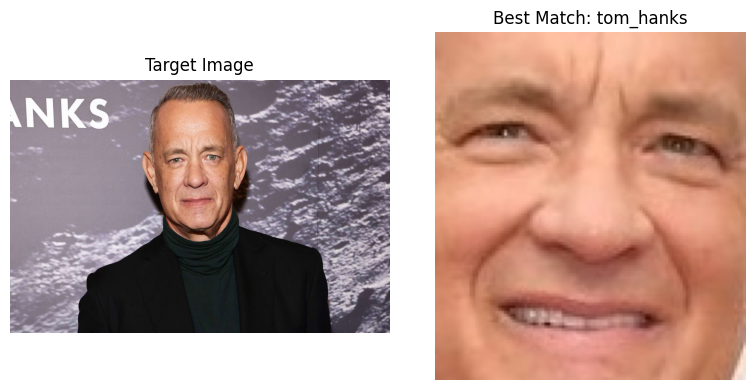


--- Testing: Angelina Jolie ---

Match found: angelina_jolie, Distance: 0.39


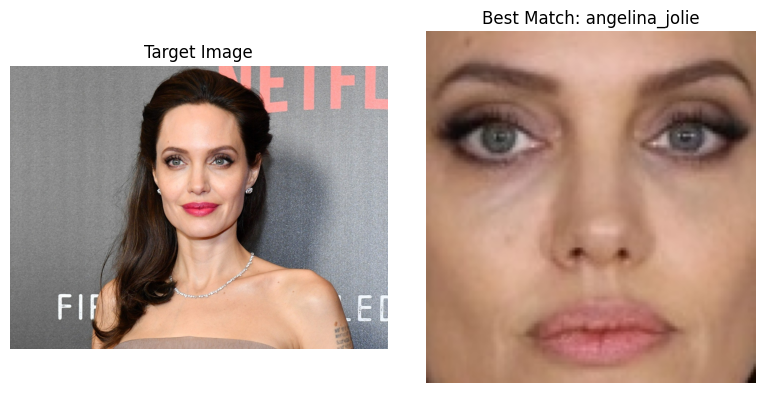


--- Testing: Seth Rogan ---

Match found: seth_rogen, Distance: 0.29


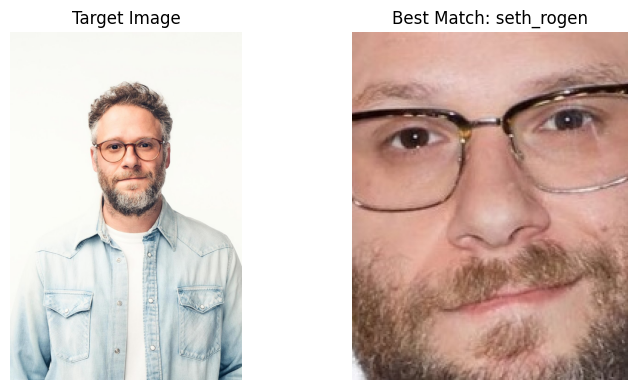


--- Testing: Kristen Stewart ---

Match found: kristen_stewart, Distance: 0.34


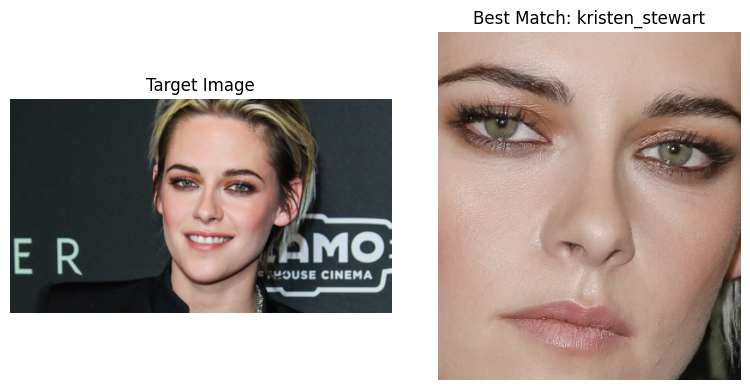


--- Testing: Denzel Washington ---

Match found: denzel_washington, Distance: 0.28


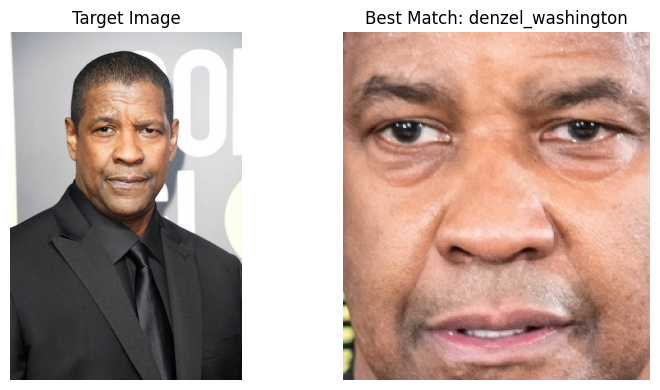


--- Testing: Emma Watson ---

Match found: emma_watson, Distance: 0.41


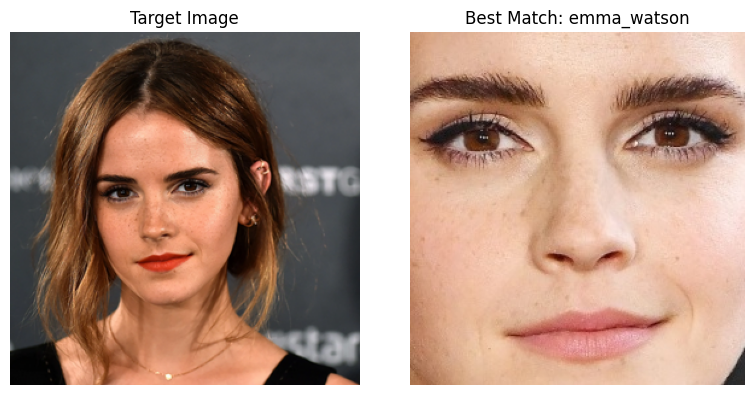

In [10]:
# Test queries
test_cases = [
    ("https://people.com/thmb/cS-3Y34QFwEbRO_x50acJP3MwbQ=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(734x348:736x350)/Tom-Hanks-That-Thing-You-Do-110624-NA-tout-d517a235093747949aec98449b8b9245.jpg", "Tom Hanks"),
    ("https://github.com/serengil/deepface/raw/master/tests/dataset/img2.jpg", "Angelina Jolie"),
    ("https://m.media-amazon.com/images/M/MV5BOGY5NTNiMmUtMjdiYi00ZmZkLTg3OTgtNDQ1OTVlZWUzY2IzXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg", "Seth Rogan"),
    ("https://media.hugogloss.uol.com.br/uploads/2023/10/Kristen-Stewart-617x347.png", "Kristen Stewart"),
    ("https://aaregistry.org/wp-content/uploads/2009/09/denzel-washington.jpg", "Denzel Washington"),
    ("https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400", "Emma Watson"),
]

# Run facial recognition
for image_url, label in test_cases:
    print(f"\n--- Testing: {label} ---")
    query_redis(image_url, index, client)

**Nice!** Now try to find other celebrity images (or your own) to see what is matched. You can toggle the `SAFE_THRESHOLD` variable to adjust the restrictiveness of the search.

## Exanple 2 -- Authentication via Facial Recog MFA

This next section demonstrates how to build a **simple authentication system** using the existing facial recognition dataset and vector search capabilities of Redis. The goal is to simulate a **multi-factor authentication (MFA)** system where users are authenticated based on:

1. **Password Validation**: A hardcoded password is checked (because this is a Lab).
2. **Claimed Identity**: The name provided by the user is compared against the database.
3. **Facial Recognition**: The user's image is matched using VSS, and the distance is validated against a configurable threshold (`SAFE_THRESHOLD`).

## How It Works
1. The user submits:
   - Their **image** (via a URL).
   - Their **name** (claimed identity).
   - A **password** (hardcoded for demo purposes).
2. The system:
   - Validates the password.
   - Converts the provided image into a vector embedding.
   - Queries Redis to find the closest match using vector similarity.
   - Checks if the name of the closest match matches the claimed identity.
   - Verifies that the similarity score (distance) is within the acceptable threshold.
3. The authentication succeeds only if **all conditions are met**.

### Here is the function that implements this simple logic


In [11]:
SAFE_THRESHOLD=0.49

def authenticate_user(
    image_url: str,
    claimed_name: str,
    password: str,
    index: SearchIndex,
    threshold: float = SAFE_THRESHOLD
):
    """
    Simulates an authentication system using vector similarity search and a hardcoded password validation.

    Args:
        image_url (str): URL of the user's image.
        claimed_name (str): Name the user is claiming to be.
        password (str): User-provided password (validated against hardcoded values).
        index (SearchIndex): Redis index to perform VSS.
        client (Redis): Redis client connection.
        threshold (float): Semantic distance threshold to determine a valid match.

    Returns:
        bool: True if authentication succeeds, False otherwise.
    """
    # Hardcoded password validation (for demonstration purposes)
    valid_password = "mypassword123"
    if password != valid_password:
        print("Authentication failed: Invalid password.")
        return False

    # Generate embedding for the provided image
    user_embedding = generate_embedding(image_url)
    if user_embedding is None:
        print("Authentication failed: Could not process the image.")
        return False

    # Query Redis for the claimed name
    query = VectorQuery(
        vector=user_embedding.tolist(),
        vector_field_name="embedding",
        return_fields=["name", "vector_distance", "photo_binary"],
        num_results=1
    )
    results = index.query(query)

    if not results:
        print("Authentication failed: No matches found.")
        return False

    # Validate the best match
    best_match = results[0]
    match_name = best_match["name"]
    match_distance = float(best_match["vector_distance"])

    if match_name != claimed_name:
        print(f"Authentication failed: Claimed name '{claimed_name}' does not match the best match '{match_name}'.")
        return False

    if match_distance > threshold:
        print(f"Authentication failed: Distance {match_distance:.2f} exceeds threshold {threshold:.2f}.")
        return False

    # If all checks pass
    print(f"Authentication succeeded for user '{claimed_name}'. Distance: {match_distance:.2f}.")
    return True

### Make sure dataset is ready to go

In [12]:
# Connect to Redis
client = get_redis_connection(REDIS_URL)

# Ensure the RedisVL index is valid
index = create_redis_index(client)

18:09:49 redisvl.index.index INFO   Index already exists, overwriting.


In [13]:
# Check if Redis already contains data
indexed_faces_count = index.info()['num_docs']
if indexed_faces_count > 0:
    print(f"Redis already contains {indexed_faces_count} records. Skipping data injection.")
else:
    # Inject data into Redis from a local dataset if no data is present
    dataset_path = "kaggle_famous_people_dataset"
    inject_local_data_into_redis(dataset_path, index)
    print("Data successfully injected into Redis.")

Redis already contains 258 records. Skipping data injection.


### Authentication flow simulation

In [14]:
# Authentication test cases
auth_test_cases = [
    {
        "image_url": "https://github.com/serengil/deepface/raw/master/tests/dataset/img2.jpg",
        "claimed_name": "angelina_jolie",
        "password": "mypassword123"
    },
    {
        "image_url": "https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400",
        "claimed_name": "hermione_granger",  # Intentional mismatch
        "password": "mypassword123"
    },
    {
        "image_url": "https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400",
        "claimed_name": "brad_pitt",
        "password": "wrongpassword"  # Intentional wrong password
    }
]

for test_case in auth_test_cases:
    print(f"\n🔍 Authenticating: {test_case['claimed_name']}...")
    success = authenticate_user(
        image_url=test_case["image_url"],
        claimed_name=test_case["claimed_name"],
        password=test_case["password"],
        index=index
    )
    if success:
        print(f"✅ Authentication succeeded for {test_case['claimed_name']}.")
    else:
        print(f"❌ Authentication failed for {test_case['claimed_name']}.")

print("\n🎉 Authentication demo completed!")


🔍 Authenticating: angelina_jolie...
Authentication succeeded for user 'angelina_jolie'. Distance: 0.39.
✅ Authentication succeeded for angelina_jolie.

🔍 Authenticating: hermione_granger...
Authentication failed: Claimed name 'hermione_granger' does not match the best match 'emma_watson'.
❌ Authentication failed for hermione_granger.

🔍 Authenticating: brad_pitt...
Authentication failed: Invalid password.
❌ Authentication failed for brad_pitt.

🎉 Authentication demo completed!


## Cleanup redis data and index

In [15]:
# clean up your index
while remaining := index.clear():
    print(f"Deleted {remaining} keys")

Deleted 258 keys
